 # Chemical Named Entity Recognition
Chemical NER is the extraction of chemical mentions from the scientific texts such as patents, bio-medical literature, patient records etc and classify them to entities such as trivial names, drugs, abbrevations, molecular formulas and IUPAC entities. In the NER system the key stages are: pre-processing methods, feature-extraction and sequence labelling approaches. 

The dataset used is the CHEMDNER corpus which consists of 10,000 MEDLINE titles and abstracts randomly partitioned to training, testing and development datasets. The articles were curated from a list of articles published in 2013 by the top 100 journals related to the chemistry field. These articles are manually annotated by domain experts. Each annotation consists of the article identifier, type of text (title or abstract), start and end indices, the text string and the label of chemical entity.

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

import nltk
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.corpus import stopwords

from chemtok import ChemTokeniser

import gensim
from gensim.models import Word2Vec, KeyedVectors

import string
import csv
import re

import sklearn_crfsuite
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_f1_score, flat_classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, cross_val_score, learning_curve
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=UserWarning)
warnings.filterwarnings('ignore',category=FutureWarning)

We first import the training data which contains article ID, title & abstracts extracted from 3500 documents and 29478 annotated entities into pandas dataframe. The annotation data contains article ID, entity type, start & end indices of entity in that article, entity name and its label.  The test data contains title and abstracts extracted from 3000 documents with 25352 annotated entities(we consider 1500 documents in the project due to memory constraints). The development data contains title & abstracts extracted from 3500 documents with 29526 annotated entities. The training, test & development data has been annotated with the following entity types: abbreviation (e.g., "DMSO"), family (e.g., "Iodopyridazines"), formula (e.g., "(CH3)2SO"), identifier (e.g., "CHEBI:28262"), multiple (e.g., "thieno2,3-d and thieno3,2-d fused oxazin-4-ones"), systematic (e.g., "2-Acetoxybenzoic acid"), trivial (e.g., "Aspirin"), and undefined/no class (e.g., "C4-C-N-PEG9") 

In [2]:
#importing training, test and development/validation dataset into dataframes
df1_train_data = pd.read_csv('training.abstracts.txt', delimiter = "\t", header=None,names=["article_ID", "title", "abstract"])
df2_train_data = pd.read_csv('training.annotations.txt', delimiter = "\t", header=None,names=["article_ID", "e_type", "start","end","entity","label"])

df1_test_data = pd.read_csv('test-abstracts.csv', nrows=1500)
df2_test_data = pd.read_csv('test-annt.csv', nrows=12824)

df1_dev_data = pd.read_csv('development.abstracts.txt', delimiter = "\t", header=None,names=["article_ID", "title", "abstract"])
df2_dev_data = pd.read_csv('development.annotations.txt', delimiter = "\t", header=None,names=["article_ID", "e_type", "start","end","entity","label"])
df1_train_data.head()

,article_ID,title,abstract
0,21826085,DPP6 as a candidate gene for neuroleptic-induc...,We implemented a two-step approach to detect p...
1,22080034,Nanosilver effects on growth parameters in exp...,Aflatoxicosis is a cause of economic losses in...
2,22080035,The influence of the intensity of smoking and ...,The aim of this study was to investigate the e...
3,22080037,Mercury induces the expression of cyclooxygena...,Nuclear factor-κB (NF-κB) is a transcription f...
4,22258629,Toxic effects of chromium on tannery workers a...,Chromium is widely used in the leather industr...


In [3]:
df2_train_data.head()

,article_ID,e_type,start,end,entity,label
0,21826085,A,946,957,haloperidol,TRIVIAL
1,22080034,A,190,199,aflatoxin,FAMILY
2,22080034,A,594,603,aflatoxin,FAMILY
3,22080034,A,718,727,aflatoxin,FAMILY
4,22080034,A,1072,1081,aflatoxin,FAMILY


We next import brown clustering files generated from 500 clusters which will be used in feature extraction stage of the process. The brown clustering algorithm is applied for training, test and development datasets and contains bitchain binary representation of word, the word and the count of number of times the word occur in that dataset.

In [4]:
df_train_brown = pd.read_csv('title_train_cluster.txt', delimiter = "\t", header=None, encoding='utf-8', names=["bitchain_title", "word_title","count_title"])
df_train_brown[["bitchain_abst", "word_abst","count_abst"]] = pd.read_csv('abstract_train_cluster.txt', delimiter = "\t", header=None, encoding='utf-8', names=["bitchain_abst", "word_abst","count_abst"])
df_test_brown = pd.read_csv('title_test_cluster.txt', delimiter = "\t", header=None, encoding='utf-8', names=["bitchain_title", "word_title","count_title"])
df_test_brown[["bitchain_abst", "word_abst","count_abst"]] = pd.read_csv('abstract_test_cluster.txt', delimiter = "\t", header=None, encoding='utf-8', names=["bitchain_abst", "word_abst","count_abst"])
df_dev_brown = pd.read_csv('title_dev_cluster.txt', delimiter = "\t", header=None, encoding='utf-8', quoting=csv.QUOTE_NONE, names=["bitchain_title", "word_title","count_title"])
df_dev_brown[["bitchain_abst", "word_abst","count_abst"]] = pd.read_csv('abstract_dev_cluster.txt',quoting=csv.QUOTE_NONE,delimiter = "\t", header=None, encoding='utf-8', names=["bitchain_abst", "word_abst","count_abst"])

df_train_brown['bitchain_title'] = df_train_brown['bitchain_title'].apply(lambda x: int(str(x)[:2]))
df_train_brown['bitchain_abst'] = df_train_brown['bitchain_abst'].apply(lambda x: int(str(x)[:2]))
df_test_brown['bitchain_title'] = df_test_brown['bitchain_title'].apply(lambda x: int(str(x)[:2]))
df_test_brown['bitchain_abst'] = df_test_brown['bitchain_abst'].apply(lambda x: int(str(x)[:2]))
df_dev_brown['bitchain_title'] = df_dev_brown['bitchain_title'].apply(lambda x: int(str(x)[:2]))
df_dev_brown['bitchain_abst'] = df_dev_brown['bitchain_abst'].apply(lambda x: int(str(x)[:2]))
df_dev_brown.head()

,bitchain_title,word_title,count_title,bitchain_abst,word_abst,count_abst
0,0,"""Chloroaluminium",1,0,"possible),",1
1,0,of,3183,0,(1995).,1
2,0,"""Absolute",1,0,14-76%,1
3,10,and,2182,0,"CHD,",1
4,10,β-galactosidase.,1,0,shRNA-mediated,1


We next import CheBI database text files which is later used for dictionary lookup feature in the feature extraction stage.

In [5]:
df_cheBI_FORMULA = pd.read_csv('chemical_data.txt', delimiter = "\t", header=None,names=["ID", "COMPOUND_ID", "SOURCE","TYPE","CHEMICAL_DATA"])
df_cheBI_IUPAC = pd.read_csv('chemical_names.txt', delimiter = "\t", header=None,names=["ID", "COMPOUND_ID", "TYPE","SOURCE","NAME",'ADAPTED','LANGUAGE'])
df_cheBI_IUPAC.head()

,ID,COMPOUND_ID,TYPE,SOURCE,NAME,ADAPTED,LANGUAGE
0,10952,16478,SYNONYM,KEGG COMPOUND,"N-Acetyl-beta-D-glucosaminyl-1,6-(N-acetyl-bet...",F,en
1,10957,15947,SYNONYM,KEGG COMPOUND,N-Acetyl-beta-D-glucosaminylamine,F,en
2,11955,7853,SYNONYM,KEGG COMPOUND,Oxyacanthine,F,en
3,11966,15379,SYNONYM,KEGG COMPOUND,O2,F,en
4,11965,15379,SYNONYM,KEGG COMPOUND,Oxygen,F,en


The pre-processing stage includes tokenization of sentences, stopwords removal, parts of speech tagging and BIO labelling of the tokens. These steps in CNER are crucial and can be challenging in identifying chemical entities, as the chemical compounds and drug names may contain a number of symbols mixed with common words or digits.  

###### Tokenization
Tokenization is the process of segmenting raw text into words/tokens. The natural language tokenisers can wrongly determine or split the chemical words containing special symbols or braces.
For example: "cyanidin-3-O-[6-O-(4-O-E-caffeoyl-O-α-rhamnopyranosyl)-β-glucopyrano]-5-O-β-glucopyranoside" is a drug which should be determined as a single token. The tokeniser should recognize such a long intact tokens which is not possible by using natural language tokenizers. To acheive this, we use chemtok module taken from OSCR project which is designed to tokenize chemical texts. 

###### Stopwords Removal
The english basic words such as "about", "all", "most", and "make" can be removed from the tokens using nltk.

###### POS tagging
A Part-Of-Speech Tagger (POS Tagger) is a module that reads text and assigns parts of speech to each word/token, such as noun, verb, adjective, etc

We first tokenize the titles of training and test data, followed by the abstracts:

In [6]:
#tokenization, stop words removal and POS tagging of titles from training dataset
df1_train_data['title_tokens'] = df1_train_data['title'].apply(lambda x: ChemTokeniser(x, clm=True))
df1_train_data['title_tokens'] = df1_train_data['title_tokens'].apply(lambda x: [x.value for x in x.tokens])
df1_train_data['title_tokens'] = df1_train_data['title_tokens'].apply(lambda x: [w for w in x if w!="."])
df1_train_data['title_tokens'] = df1_train_data['title_tokens'].apply(lambda x: [w for w in x if w not in stopwords.words('english')])
df1_train_data['title_tag'] = df1_train_data['title_tokens'].apply(lambda x: nltk.pos_tag(x))

#tokenization, stop words removal and POS tagging of titles from test dataset
df1_test_data['title_tokens'] = df1_test_data['title'].apply(lambda x: ChemTokeniser(x, clm=True))
df1_test_data['title_tokens'] = df1_test_data['title_tokens'].apply(lambda x: [x.value for x in x.tokens])
df1_test_data['title_tokens'] = df1_test_data['title_tokens'].apply(lambda x: [w for w in x if w!="."])
df1_test_data['title_tokens'] = df1_test_data['title_tokens'].apply(lambda x: [w for w in x if w not in stopwords.words('english')])
df1_test_data['title_tag'] = df1_test_data['title_tokens'].apply(lambda x: nltk.pos_tag(x))

#tokenization, stop words removal and POS tagging of titles from development dataset
df1_dev_data['title_tokens'] = df1_dev_data['title'].apply(lambda x: ChemTokeniser(x, clm=True))
df1_dev_data['title_tokens'] = df1_dev_data['title_tokens'].apply(lambda x: [x.value for x in x.tokens])
df1_dev_data['title_tokens'] = df1_dev_data['title_tokens'].apply(lambda x: [w for w in x if w!="."])
df1_dev_data['title_tokens'] = df1_dev_data['title_tokens'].apply(lambda x: [w for w in x if w not in stopwords.words('english')])
df1_dev_data['title_tag'] = df1_dev_data['title_tokens'].apply(lambda x: nltk.pos_tag(x))

df1_train_data.head()

,article_ID,title,abstract,title_tokens,title_tag
0,21826085,DPP6 as a candidate gene for neuroleptic-induc...,We implemented a two-step approach to detect p...,"[DPP6, candidate, gene, neuroleptic, -, induce...","[(DPP6, NNP), (candidate, NN), (gene, NN), (ne..."
1,22080034,Nanosilver effects on growth parameters in exp...,Aflatoxicosis is a cause of economic losses in...,"[Nanosilver, effects, growth, parameters, expe...","[(Nanosilver, NNP), (effects, NNS), (growth, N..."
2,22080035,The influence of the intensity of smoking and ...,The aim of this study was to investigate the e...,"[The, influence, intensity, smoking, years, wo...","[(The, DT), (influence, NN), (intensity, NN), ..."
3,22080037,Mercury induces the expression of cyclooxygena...,Nuclear factor-κB (NF-κB) is a transcription f...,"[Mercury, induces, expression, cyclooxygenase-...","[(Mercury, NNP), (induces, NNS), (expression, ..."
4,22258629,Toxic effects of chromium on tannery workers a...,Chromium is widely used in the leather industr...,"[Toxic, effects, chromium, tannery, workers, S...","[(Toxic, NNP), (effects, NNS), (chromium, VBP)..."


In [7]:
#tokenization, stop words removal and POS tagging of abstracts from training dataset
df1_train_data['abstract_tokens'] = df1_train_data['abstract'].apply(lambda x: ChemTokeniser(x, clm=True))
df1_train_data['abstract_tokens'] = df1_train_data['abstract_tokens'].apply(lambda x: [x.value for x in x.tokens])
df1_train_data['abstract_tokens'] = df1_train_data['abstract_tokens'].apply(lambda x: [w for w in x if w!="."])
df1_train_data['abstract_tokens'] = df1_train_data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords.words('english')])
df1_train_data['abstract_tag'] = df1_train_data['abstract_tokens'].apply(lambda x: nltk.pos_tag(x))

#tokenization, stop words removal and POS tagging of abstracts from test dataset
df1_test_data['abstract_tokens'] = df1_test_data['abstract'].apply(lambda x: ChemTokeniser(x, clm=True))
df1_test_data['abstract_tokens'] = df1_test_data['abstract_tokens'].apply(lambda x: [x.value for x in x.tokens])
df1_test_data['abstract_tokens'] = df1_test_data['abstract_tokens'].apply(lambda x: [w for w in x if w!="."])
df1_test_data['abstract_tokens'] = df1_test_data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords.words('english')])
df1_test_data['abstract_tag'] = df1_test_data['abstract_tokens'].apply(lambda x: nltk.pos_tag(x))

#tokenization, stop words removal and POS tagging of abstracts from development dataset
df1_dev_data['abstract_tokens'] = df1_dev_data['abstract'].apply(lambda x: ChemTokeniser(x, clm=True))
df1_dev_data['abstract_tokens'] = df1_dev_data['abstract_tokens'].apply(lambda x: [x.value for x in x.tokens])
df1_dev_data['abstract_tokens'] = df1_dev_data['abstract_tokens'].apply(lambda x: [w for w in x if w!="."])
df1_dev_data['abstract_tokens'] = df1_dev_data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords.words('english')])
df1_dev_data['abstract_tag'] = df1_dev_data['abstract_tokens'].apply(lambda x: nltk.pos_tag(x))

df1_train_data.head()

,article_ID,title,abstract,title_tokens,title_tag,abstract_tokens,abstract_tag
0,21826085,DPP6 as a candidate gene for neuroleptic-induc...,We implemented a two-step approach to detect p...,"[DPP6, candidate, gene, neuroleptic, -, induce...","[(DPP6, NNP), (candidate, NN), (gene, NN), (ne...","[We, implemented, two, -, step, approach, dete...","[(We, PRP), (implemented, VBD), (two, CD), (-,..."
1,22080034,Nanosilver effects on growth parameters in exp...,Aflatoxicosis is a cause of economic losses in...,"[Nanosilver, effects, growth, parameters, expe...","[(Nanosilver, NNP), (effects, NNS), (growth, N...","[Aflatoxicosis, cause, economic, losses, broil...","[(Aflatoxicosis, NNP), (cause, VBP), (economic..."
2,22080035,The influence of the intensity of smoking and ...,The aim of this study was to investigate the e...,"[The, influence, intensity, smoking, years, wo...","[(The, DT), (influence, NN), (intensity, NN), ...","[The, aim, study, investigate, effect, cigaret...","[(The, DT), (aim, NN), (study, NN), (investiga..."
3,22080037,Mercury induces the expression of cyclooxygena...,Nuclear factor-κB (NF-κB) is a transcription f...,"[Mercury, induces, expression, cyclooxygenase-...","[(Mercury, NNP), (induces, NNS), (expression, ...","[Nuclear, factor-κB, (, NF-κB, ), transcriptio...","[(Nuclear, JJ), (factor-κB, JJ), ((, (), (NF-κ..."
4,22258629,Toxic effects of chromium on tannery workers a...,Chromium is widely used in the leather industr...,"[Toxic, effects, chromium, tannery, workers, S...","[(Toxic, NNP), (effects, NNS), (chromium, VBP)...","[Chromium, widely, used, leather, industry, ,,...","[(Chromium, NNP), (widely, RB), (used, VBD), (..."


##### BIO Tagging
The BIO format is a common tagging format for tagging tokens in a NER system. The "B-" prefix before a tag indicates that the tag is the beginning of a chunk, and an "I-" prefix before a tag indicates that the tag is inside a chunk. The "B-" tag is used only when a tag is followed by a tag of the same type without O tokens between them. An "O" tag indicates that a token belongs to no entity / chunk.

E.g.,: "Mercury induces the expression of cyclooxygenase-2 and inducible nitric oxide synthase"<br>
BIO tag: Mercury/B/induces/O/expression/O/cyclooxygenase-2/O/inducible/O/nitric/B/Oxide/I/synthase/O

In [8]:
#BIO tagging of title and abstracts
def mark_sentences_bio(df1,df2):
    doc_t, doc_a = [],[]
    tit,tagged_t,bitchain_t = [],[],[]
    #BIO tagging of abstracts
    for article_id,title,title_tok,title_tag in zip(df1.article_ID,df1.title,df1.title_tokens,df1.title_tag):
        word_dict = {}
        bit_dict_t = {}
        for word in title_tok:
            word_dict[word] = 'O'               
        for art_id,start,end,label in zip(df2.article_ID,df2.start,df2.end,df2.label):
            if(article_id==art_id):
                temp_str = title[int(start):int(end)]
                temp_list = temp_str.split()
                if len(temp_list) > 1:
                    word_dict[temp_list[0]] = 'B-' + label
                    for w in temp_list[1:]:
                        word_dict[w] = 'I-' + label
                else: 
                    word_dict[temp_str] = 'B-' + label
                if temp_str not in title_tok and temp_str!='':
                    title_tag.append((temp_str,''))
        tit.append([(k,v) for k, v in word_dict.items() if k!=''])
        tagged_t.append(title_tag)
    #assigning POS and entity label to each word
    for  label, pos in zip(tit, tagged_t):
        doc_t.append([(w, pos1, label1) for (w,label1),(word,pos1) in zip(label,pos)])
                                                
    abst,tagged_a,bitchain_a = [],[],[]
    #BIO tagging of abstracts
    for art_id,abstract,abstract_tok,abstract_tag in zip(df1.article_ID,df1.abstract,df1.abstract_tokens,df1.abstract_tag):
        word_dict = {}
        bit_dict_a = {}
        for w in abstract_tok:
            word_dict[w] = 'O'                 
        for ar_id,start,end,label in zip(df2.article_ID,df2.start,df2.end,df2.label):
            if(art_id==ar_id):
                temp_str = abstract[int(start):int(end)]
                temp_list = temp_str.split()
                if len(temp_list) > 1:
                    word_dict[temp_list[0]] = 'B-' + label
                    for w in temp_list[1:]:
                        word_dict[w] = 'I-' + label
                else: 
                    word_dict[temp_str] = 'B-' + label
                if temp_str not in abstract_tok and temp_str!='':
                    abstract_tag.append((temp_str,''))
        abst.append([(k, v) for k, v in word_dict.items()])
        tagged_a.append(abstract_tag)
    #assigning POS and entity label to each word
    for  label, pos in zip(abst, tagged_a):
        doc_a.append([(w, pos1, label1) for (w,label1),(word,pos1) in zip(label,pos)])
    return doc_t,doc_a

In [9]:
#BIO tagging of training dataset
res_t = mark_sentences_bio(df1_train_data,df2_train_data)
print(res_t[0][3])

#BIO tagging of test dataset
res_a = mark_sentences_bio(df1_test_data,df2_test_data)

#BIO tagging of development dataset
res_d = mark_sentences_bio(df1_dev_data,df2_dev_data)

[('Mercury', 'NNP', 'B-SYSTEMATIC'), ('induces', 'NNS', 'O'), ('expression', 'VBP', 'O'), ('cyclooxygenase-2', 'JJ', 'O'), ('inducible', 'JJ', 'O'), ('nitric', 'JJ', 'B-SYSTEMATIC'), ('oxide', 'NN', 'I-SYSTEMATIC'), ('synthase', 'NN', 'O')]


### Feature Extraction

In the Feature extraction stage, the feature space is being represented in which different types of features are being used to generate the characteristics of the tokens/words. This is the most critical stage of NER, as the machine learning model can be better trained using different word features and representations. We use different categories of feature extraction such as morphological features, orthographical features, chemical dictionary lookup and unsupervised word representation.

#### Morphological features:
Reflects common structures and sub-sequences of characters among entities. Such as, prefixes, suffixes, 
char n-grams:bigrams,trigrams, word-shape patterns(e.g.,the structure "Abc:1234" can be expressed as "Aaa#1111")

#### Orthographical features:
Represents word formation information, such as, capital letters, length of the word, ContainsDigits, ContainsPunctutaion, ContainsRoman, ContainsGreek

#### Chemical dictionary lookup:
Recognising that the occurrence of a token in an expert-curated dictionary indicates a high likelihood of it being a chemical name constituent. Dictionaries of chemicals are used to match the tokens/words. We have used Chemical Entities of Biological Interest (ChEBI) database to match chemical formulas and names.

#### Unsupervised word representation
If new terms show up in the test cases that have not been seen previously in the training dataset, we should adopt unsupervised WR like clustering for such words. We use two types of clustering approaches that are used widely in recognizing chemical entities:<br>

**Brown Clustering**: Brown clustering builds a hierarchical cluster for words according to the context similarity
among those words. The hierarchical path of a word in the cluster can be used as the word representation feature.
We followed the method in (https://github.com/percyliang/brown-cluster/) to generate Brown clustering features. The hierarchical clusters are represented by a binary tree and words that are semantically/
syntactically similar are assumed to be in the same or close clusters and have similar feature representations. For example, both of the words, oxygen and nitrogen are represented as ‘110110110110’ from the hierarchical binary
tree generated from 500 Brown clusters.

**Word Embeddings**: Word embeddings induce a real valued latent syntactic/semantic vector for each word from large corpus by continuous space language models. A word can be directly represented by its vector and similar words are likely to have similar vectors. A word2vec statistical neural network model is used to generate standalone word embeddings. Two different learning models can be used as part of the word2vec approach to learn the word embeddings they are:<br>
* The CBOW model: learns the embedding by predicting the current word based on its context.<br>
* The skip-gram model: learns by predicting the surrounding words given a current word.


In [10]:
#assigning bitchain binary representation for each word in the dataset
def get_bitchain(df1,df2,res):
    bitchain_t,bitchain_a,data = [],[],[]
    for doc_t,doc_a in zip(res[0],res[1]):
        bitchain_dict_t, bitchain_dict_a= {},{}
        for word in doc_t:
            bitchain_title_train = df2['bitchain_title'].loc[df2['word_title'] == word[0]].values[-1:]
            if (len(bitchain_title_train)==0): bitchain = ""
            else:             
                for k in range(len(bitchain_title_train)):
                    bitchain = bitchain_title_train[-k-1]
            bitchain_dict_t[word[0]] = bitchain
        #assigning bitchain for each word in title
        bitchain_t.append([(l,m) for l,m in bitchain_dict_t.items()])
        
        for w in doc_a:
            bitchain_abst_train = df2['bitchain_abst'].loc[df2['word_abst'] == w[0]].values[-1:]
            if (len(bitchain_abst_train)==0): bitchain = ""
            else:             
                for k in range(len(bitchain_abst_train)):
                    bitchain = bitchain_abst_train[-k-1]
            bitchain_dict_a[w[0]] = bitchain           
        bitchain_a.append([(l,m) for l,m in bitchain_dict_a.items()]) 
    #assigning bitchain for each word in abstract
    for doc,bitchain in zip(res[0],bitchain_t):
        data.append([(w, pos1, label1,bit) for (w, pos1, label1),(word,bit) in zip(doc,bitchain)])
    for doc,bitchain in zip(res[1],bitchain_a):
        data.append([(w, pos1, label1,bit) for (w, pos1, label1),(word,bit) in zip(doc,bitchain)])
    return data

In [11]:
#assigning bitchain for each token in training data
data_train = get_bitchain(df1_train_data,df_train_brown,res_t)
print(data_train[3])

#assigning bitchain for each token in test data
data_test = get_bitchain(df1_test_data,df_test_brown,res_a)

#assigning bitchain for each token in development data
data_dev = get_bitchain(df1_dev_data,df_dev_brown,res_a)

[('Mercury', 'NNP', 'B-SYSTEMATIC', ''), ('induces', 'NNS', 'O', 10), ('expression', 'VBP', 'O', 11), ('cyclooxygenase-2', 'JJ', 'O', 10), ('inducible', 'JJ', 'O', 10), ('nitric', 'JJ', 'B-SYSTEMATIC', 11), ('oxide', 'NN', 'I-SYSTEMATIC', 11), ('synthase', 'NN', 'O', 11)]


In [12]:
#generating word embeddings using word2vec model for each tokens
df_token_data = []
for index,row in df1_train_data.iterrows():
    df_token_data.append(row['title_tokens'])
    df_token_data.append(row['abstract_tokens'])
for index,row in df1_test_data.iterrows():
    df_token_data.append(row['title_tokens'])
    df_token_data.append(row['abstract_tokens'])
    
model = Word2Vec(sentences=df_token_data,vector_size=100, window=5, min_count=1, workers=4)
model.save('model.bin')

#load and train the model
model = Word2Vec.load('model.bin')
model.train(df_token_data, total_examples=1, epochs=1)
word_vectors = model.wv

#save the model
word_vectors.save("word2vec.wordvectors")

#load the model in keyedVectors format which occupies less data 
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
def get_features(word):
    word=word.lower()
    try:
        #word embeddings of each word/token is represented in vector
         vector=wv[word]
    except:
        # if the word is not in vocabulary,
        # returns zeros array
        vector=np.zeros(300,dtype='uint8')
    return vector 

Generating features of word which can be fed to train the model. The crf model used in our project accepts features in dictionary format as shown below:

In [13]:
#generating morphological, orthographic, dictionary lookup, wordembedding, brown cluster features for word/token
def word2features(doc, i):
    word = doc[i][0]
    postag = doc[i][1]
    bitchain = doc[i][3]
 
    punct = set(string.punctuation)
    #common prefixes used in chemical data
    pref = ["alk", "meth", "eth", "prop", "but", "pent", "hex", "hept", "oct", "non", "dec", "undec", "dodec", "eifcos",
            "di", "tri", "tetra", "penta", "hexa", "hepta"]
    #common suffixes used in chemical data
    suff = ["ane", "ene", "yne", "yl", "ol", "al", "oic", "one", "ate", "amine", "amide"]
    
    #bigrams of word
    bi_g = [word[w:w+2] for w in range(len(word)-1)]
    #trigrams of word
    tri_g = [word[w:w+3] for w in range(len(word)-2)]
    
    #word pattern
    pattern = re.sub(r"[A-Z]","A",word)
    pattern = re.sub(r"[a-z]","a",pattern)
    pattern = re.sub(r"[0-9]","0",pattern)
    pattern = re.sub(r"[!""#$%&'()*+,./:;<=>?@\^_`{|}~-]","_",pattern)
    pattern = re.sub(r"(.)\1+", r"\1",pattern)
    
    #wordembedding vector of each word
    wordembedding=get_features(word)
    #chemical database lookup
    isinChEBIFormula = word in df_cheBI_FORMULA.CHEMICAL_DATA
    isinChEBIIUPAC = word in df_cheBI_IUPAC.NAME

    # Common features for all words
    features = {
        'bias':1.0,
        'word.lower()' : word.lower(),
        'word.islower()' : word.islower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),        
        'word[0].isupper()' : word[0:].isupper(),
        'word.length' : len(word),
        'word.punctuation' : (any(char in punct for char in word)),
        'word.prefix' : (any(word.startswith(pf) for pf in pref)),
        'word.suffix' : (any(word.endswith(sf) for sf in suff)),
        'word.greek' : (bool(re.search('[α-ωΑ-Ω]',word))),
        'word.roman' : (bool(re.search(r"^M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$",word))),
        'word.pattern' : pattern,
        'word.bitchain': bitchain,
        'word.isinChEBIFormula': isinChEBIFormula,
        'word:isinChEBIIUPAC' : isinChEBIIUPAC,
        'postag' : postag,
        'postag[:2]': postag[:2]   
    }
    for j in range(len(bi_g)):
        features['bigram_{}'.format(j+1)]=bi_g[j]
    for j in range(len(tri_g)):
        features['trigram_{}'.format(j+1)]=tri_g[j]    
    for iv,value in enumerate(wordembedding):
        features['v{}'.format(iv)]=value    

    # Features for words that are not
    # at the beginning of a document
    if i > 0:
        word1 = doc[i-1][0]
        postag1 = doc[i-1][1]
        bitchain1 = doc[i-1][3]
        pattern1 = re.sub(r"[A-Z]","A",word1)
        pattern1 = re.sub(r"[a-z]","a",pattern1)
        pattern1 = re.sub(r"[0-9]","0",pattern1)
        pattern1 = re.sub(r"[!""#$%&'()*+,./:;<=>?@\^_`{|}~-]","_",pattern1)
        pattern1 = re.sub(r"(.)\1+", r"\1",pattern1)      
        bi_g1 = [word1[w:w+2] for w in range(len(word1)-1)]
        tri_g1 = [word1[w:w+3] for w in range(len(word1)-2)]  
        wordembedding1=get_features(word1)  
        isinChEBIFormula1 = word1 in df_cheBI_FORMULA.CHEMICAL_DATA
        isinChEBIIUPAC1 = word1 in df_cheBI_IUPAC.NAME
        features.update({
            '-1:word.lower()' : word1.lower(),
            '-1:word.islower()' : word1.islower(),
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word.isupper()': word1.isupper(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isdigit()': word1.isdigit(),        
            '-1:word[0].isupper()' : word1[0:].isupper(),
            '-1:word.length' : len(word1),
            '-1:word.punctuation' : (any(char in punct for char in word1)),
            '-1:word.prefix' : (any(word1.startswith(pf) for pf in pref)),
            '-1:word.suffix' : (any(word1.endswith(sf) for sf in suff)),
            '-1:word.greek' : (bool(re.search('[α-ωΑ-Ω]',word1))),
            '-1:word.roman' : (bool(re.search(r"^M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$",word1))),
            '-1:postag' : postag1,         
            '-1:word.pattern' : pattern1,  
            '-1:word.bitchain': bitchain1,
            '-1:word.isinChEBIFormula': isinChEBIFormula1,
            '-1:word:isinChEBIIUPAC' : isinChEBIIUPAC1,
            '-1:postag[:2]': postag1[:2]
        })
        for j in range(len(bi_g1)):
            features['-1:bigram_{}'.format(j+1)]=bi_g1[j]
        for j in range(len(tri_g1)):
            features['-1:trigram_{}'.format(j+1)]=tri_g1[j]  
        for iv,value in enumerate(wordembedding1):
            features['-1:v{}'.format(iv)]=value
    else:
        # Indicate that it is the 'beginning of a document'
        features['BOS'] = True

    # Features for words that are not
    # at the end of a document
    if i < len(doc)-1:
        word1 = doc[i+1][0]
        postag1 = doc[i+1][1]
        bitchain1 = doc[i+1][3]

        pattern1 = re.sub(r"[A-Z]","A",word1)
        pattern1 = re.sub(r"[a-z]","a",pattern1)
        pattern1 = re.sub(r"[0-9]","0",pattern1)
        pattern1 = re.sub(r"[!""#$%&'()*+,./:;<=>?@\^_`{|}~-]","_",pattern1)
        pattern1 = re.sub(r"(.)\1+", r"\1",pattern1)      
        bi_g1 = [word1[w:w+2] for w in range(len(word1)-1)]
        tri_g1 = [word1[w:w+3] for w in range(len(word1)-2)]  
        wordembedding1=get_features(word1)        
        isinChEBIFormula1 = word1 in df_cheBI_FORMULA.CHEMICAL_DATA
        isinChEBIIUPAC1 = word1 in df_cheBI_IUPAC.NAME
        features.update({
            '+1:word.lower()' : word1.lower(),
            '+1:word.islower()' : word1.islower(),
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.isupper()': word1.isupper(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isdigit()': word1.isdigit(),        
            '+1:word[0].isupper()' : word1[0:].isupper(),
            '+1:word.length' : len(word1),
            '+1:word.punctuation' : (any(char in punct for char in word1)),
            '+1:word.prefix' : (any(word1.startswith(pf) for pf in pref)),
            '+1:word.suffix' : (any(word1.endswith(sf) for sf in suff)),
            '+1:word.greek' : (bool(re.search('[α-ωΑ-Ω]',word1))),
            '+1:word.roman' : (bool(re.search(r"^M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$",word1))),            
            '+1:word.pattern' : pattern1,
            '+1:word.isinChEBIFormula': isinChEBIFormula1,
            '+1:word:isinChEBIIUPAC' : isinChEBIIUPAC1,
            '+1:postag' : postag1,
            '+1:postag[:2]': postag1[:2]
        })
        for i in range(len(bi_g1)):
            features['+1:bigram_{}'.format(i+1)]=bi_g1[i]
        for i in range(len(tri_g1)):
            features['+1:trigram_{}'.format(i+1)]=tri_g1[i]  
        for iv,value in enumerate(wordembedding1):
            features['+1:v{}'.format(iv)]=value                  

    else:
        # Indicate that it is the 'end of a document'
        features['EOS'] = True
    return features

In [14]:
def extract_features(doc):
    return [word2features(doc, i) for i in range(len(doc))]
def get_labels(doc):
    return [label for (token, postag, label,bitchain) in doc]

In [15]:
#generating word features for training data
X_train = [extract_features(doc) for doc in data_train]
y_train = [get_labels(doc) for doc in data_train]

In [16]:
#generating word features for test data
X_test = [extract_features(doc) for doc in data_test]
y_test = [get_labels(doc) for doc in data_test]

In [17]:
#generating word features for development data
X_dev = [extract_features(doc) for doc in data_dev]
y_dev = [get_labels(doc) for doc in data_dev]

### Training CRF Model
In this stage, the training data can be used to train a CRF (conditional random fields) model using the extracted features. CRFs are graphical model which implements sequential dependencies in the predictions, i.e., the model predicts many variables that are interdependent. The main challenge in the NER problem is that the too rare entities can occur in test set due to which model must identify based only on context. The naive approach to this problem is to classify each word independently which assumes that named entity labels are independent which is not the case.<br><br>
For example: tenofovir is classified as TRIVIAL name, where as tenofovir monophosphate is classified as SYSTEMATIC name.<br><br>
To tackle this problem we use CRFs where input data is sequence and output is also a sequence and we have to take the previous context into account when predicting on a data point. For this purpose, we will use a feature functions that will have multiple input values.<br><br>

The feature function is defined as follows:<br>
       &emsp;&emsp;&emsp;&emsp;f(X,i,Yi-1,Yi) <br>
Where, X = set of input vectors<br>
       i = position of data points that we want to predict<br>
       Y(i-1) = the label of data point i-1 in X<br>
       Yi = the label of data point i in X

In [18]:
#model training of training dataset
crf = CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [19]:
#eliminating entities which are not chemical mentions and are represented by 'O' tags
labels = list(crf.classes_)
labels.remove('O')
labels

['B-SYSTEMATIC',
 'I-SYSTEMATIC',
 'B-FAMILY',
 'I-FAMILY',
 'B-ABBREVIATION',
 'B-TRIVIAL',
 'I-TRIVIAL',
 'I-MULTIPLE',
 'B-MULTIPLE',
 'B-IDENTIFIER',
 'B-FORMULA',
 'I-FORMULA',
 'I-ABBREVIATION',
 'I-IDENTIFIER',
 'B-NO CLASS',
 'I-NO CLASS']

### Evaluating the Model Performance
We will use precision, recall and f1-score metrics to evaluate the performance of the model. The recall, precision and f-measure are defined as follows.<br><br>
recall=TP/TP+FN, &emsp;&emsp; precision=TP/TP+FP,&emsp;&emsp; f-measure=(2 * precision * recall)/(precision+recall)<br><br>
Where,True positive (TP) refers to the number of correctly recognized chemical mentions. False negative (FN) is the number of annotated chemical mentions that were omitted by the presented system. False positive (FP) is the number of recognized chemical mentions that were not annotated.

In [20]:
#predicting entity recognition of test data
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted',labels=labels)

0.551359721015118

The following results shows the precision, recall & f-measure of recognizing entities of test data when we train the crf model using training data

In [21]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=2
))

                precision    recall  f1-score   support

B-ABBREVIATION       0.81      0.49      0.61       952
I-ABBREVIATION       0.00      0.00      0.00        20
      B-FAMILY       0.63      0.47      0.54      1840
      I-FAMILY       0.38      0.27      0.31      1136
     B-FORMULA       0.78      0.69      0.73       954
     I-FORMULA       0.14      0.05      0.08        55
  B-IDENTIFIER       0.74      0.21      0.33       163
  I-IDENTIFIER       0.00      0.00      0.00        33
    B-MULTIPLE       0.25      0.07      0.10        91
    I-MULTIPLE       0.46      0.21      0.28       228
    B-NO CLASS       0.00      0.00      0.00        11
    I-NO CLASS       0.00      0.00      0.00         2
  B-SYSTEMATIC       0.69      0.65      0.67      2694
  I-SYSTEMATIC       0.43      0.35      0.39      1474
     B-TRIVIAL       0.74      0.63      0.68      3142
     I-TRIVIAL       0.44      0.28      0.34      1054

     micro avg       0.64      0.50      0.56 

We now train the crf development/validation dataset to improve the quality of the results

In [22]:
crf_dev = CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True)
crf_dev.fit(X_dev, y_dev)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [23]:
labels_dev = list(crf_dev.classes_)
labels_dev.remove('O')
labels_dev

['B-SYSTEMATIC',
 'I-SYSTEMATIC',
 'I-FAMILY',
 'B-FAMILY',
 'B-TRIVIAL',
 'I-TRIVIAL',
 'B-FORMULA',
 'I-FORMULA',
 'B-ABBREVIATION',
 'B-IDENTIFIER',
 'I-IDENTIFIER',
 'B-NO CLASS',
 'I-MULTIPLE',
 'B-MULTIPLE',
 'I-ABBREVIATION',
 'I-NO CLASS']

#### Hyperparameter Optimization
To perform optimization, we can do the regularization of parameters c1 and c2 of the model using randomized search and 3-fold cross-validation for 5 iterations(upto 50 iterations can also be performed given better CPU time and memory limit) and fit the development/validation dataset for the optimized parameters. Then we evaluate the model on the test data.


In [24]:
%%time
import scipy.stats
from itertools import chain
from sklearn.metrics import make_scorer

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}


f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels_dev)

rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=1,
                        n_iter=5,
                        scoring=f1_scorer)
rs.fit(X_dev, y_dev)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 138.7min finished


Wall time: 2h 27min 17s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=5, n_jobs=1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028B6BD736D0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028B6BD73280>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-SYSTEMATIC', 'I-SYSTEMATIC', 'I-FAMILY', 'B-FAMILY', 'B-TRIVIAL', 'I-TRIVIAL', 'B-FORMULA', 'I-FORMULA', 'B-ABBREVIATION', 'B-IDENTIFIER', 'I-IDENTIFIER', 'B-NO CLASS', 'I-MULTIPLE', 'B-MULTIPLE', 'I-ABBREVIATION', 'I-NO CLASS']),
                   verbose=1)

In [25]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.08894140215067371, 'c2': 0.0020242384494808985}
best CV score: 0.512885774771498
model size: 5.60M


Checking best estimator on our test data. The f1 score and precision, recall score are improved.

In [27]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)

metrics.flat_f1_score(y_test, y_pred,
                      average='weighted',labels=labels_dev)

0.9925771828887452

We observe from the below results that training & optimizing the model with the development/validation data gave better results in recognizing the chemical entities of test data than the training data.

In [28]:
sorted_labels = sorted(
    labels_dev,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=2
))

                precision    recall  f1-score   support

B-ABBREVIATION       1.00      1.00      1.00       952
I-ABBREVIATION       1.00      1.00      1.00        20
      B-FAMILY       1.00      0.99      0.99      1840
      I-FAMILY       0.99      0.97      0.98      1136
     B-FORMULA       1.00      1.00      1.00       954
     I-FORMULA       1.00      1.00      1.00        55
  B-IDENTIFIER       1.00      0.99      0.99       163
  I-IDENTIFIER       1.00      1.00      1.00        33
    B-MULTIPLE       1.00      1.00      1.00        91
    I-MULTIPLE       1.00      1.00      1.00       228
    B-NO CLASS       1.00      1.00      1.00        11
    I-NO CLASS       1.00      1.00      1.00         2
  B-SYSTEMATIC       1.00      0.99      1.00      2694
  I-SYSTEMATIC       0.99      0.97      0.98      1474
     B-TRIVIAL       1.00      0.99      1.00      3142
     I-TRIVIAL       1.00      0.97      0.98      1054

     micro avg       1.00      0.99      0.99 

Below shows what the classifier learned. We can see that, for example, it is very likely that the beginning of an identifier name (B-IDENTIFIER) will be followed by a token inside identifier name (I-IDENTIFIER)

In [34]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-NO CLASS -> I-NO CLASS 6.722555
B-IDENTIFIER -> I-IDENTIFIER 6.414588
B-ABBREVIATION -> I-ABBREVIATION 5.908931
B-FAMILY -> I-FAMILY 5.195519
B-MULTIPLE -> I-MULTIPLE 5.169787
B-FORMULA -> I-FORMULA 4.823790
I-MULTIPLE -> I-MULTIPLE 4.794898
B-SYSTEMATIC -> I-SYSTEMATIC 4.629315
B-TRIVIAL -> I-TRIVIAL 4.628872
B-FORMULA -> B-FORMULA 3.637423
I-FAMILY -> I-FAMILY 3.486416
I-SYSTEMATIC -> I-SYSTEMATIC 3.412703
B-NO CLASS -> B-NO CLASS 3.306423
I-FORMULA -> I-FORMULA 3.281422
I-IDENTIFIER -> I-IDENTIFIER 3.101716
I-TRIVIAL -> I-TRIVIAL 2.496813
O      -> O       2.037894
B-ABBREVIATION -> B-ABBREVIATION 1.882757
I-TRIVIAL -> B-ABBREVIATION 1.539906
I-FORMULA -> B-FORMULA 1.519302

Top unlikely transitions:
B-MULTIPLE -> B-FORMULA -1.433482
I-SYSTEMATIC -> I-IDENTIFIER -1.466668
I-FORMULA -> B-SYSTEMATIC -1.473499
B-SYSTEMATIC -> I-MULTIPLE -1.536675
B-FAMILY -> I-IDENTIFIER -1.576991
I-MULTIPLE -> I-TRIVIAL -1.578228
B-TRIVIAL -> I-FAMILY -1.589689
O      -> I-ID

The performance of the model can be evaluated using a learning curve, plotting the accuracy/score of predictions on the development and test datasets. As more data is fed for training the model, the accuracy on the test data increases with increase in the number of training samples.

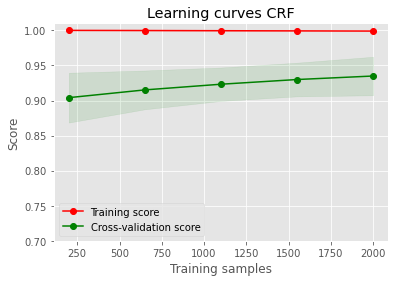

In [35]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

estimator=crf_dev
title = "Learning curves CRF"

plot_learning_curve(estimator, title, X_dev, y_dev,(0.7, 1.01), cv=3, n_jobs=1)

plt.show()